<h1>Математические основы машинного обучения III (часть 2)</h1>


<h2>Итоговый проект "Анализ временных рядов"

<h2>5. Классификация временных рядов

In [70]:
# импорт необходимых библиотек

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates #Date Parser

import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

In [71]:
# импорт необходимых библиотек

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import sktime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
smape = MeanAbsolutePercentageError(symmetric = True)
rmse  = MeanSquaredError(square_root=True)

from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import make_pipeline

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

from sktime.transformations.panel.rocket import MiniRocket
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sktime.datatypes import convert_to

In [247]:
# считываем ранее подготовленные данные

data = pd.read_csv('data.csv', index_col='timestamp', parse_dates=True)

In [73]:
data.sample(5)

,value,h
timestamp,,
2015-03-15 05:00:00,464,60
2015-03-31 18:00:00,1277,216
2015-03-10 19:00:00,909,228
2015-04-22 08:00:00,314,96
2015-03-29 10:00:00,335,120


Попробуем разработать классификатор дней недели (выходной/рабочий) по почасовому упоминанию Амазон в Твиттер

In [248]:
data['day_of_the_week'] = pd.to_datetime(data.index).weekday
data.sample(5)

,value,h,day_of_the_week
timestamp,,,
2015-04-14 14:00:00,956,168,1
2015-04-10 16:00:00,898,192,4
2015-03-24 15:00:00,888,180,1
2015-02-26 22:00:00,931,264,3
2015-03-22 09:00:00,360,108,6


In [75]:
# функция сигментации данных
def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

Создаём массивы сегментированных данных для рабочих дней и выходных

In [76]:
#monday = to_segments(data[data['day_of_the_week'] == 0], 'value', size = 24)
#tuesday = to_segments(data[data['day_of_the_week'] == 1], 'value', size = 24)
#wednesday = to_segments(data[data['day_of_the_week'] == 2], 'value', size = 24)
#turhday = to_segments(data[data['day_of_the_week'] == 3], 'value', size = 24)
#friday = to_segments(data[data['day_of_the_week'] == 4], 'value', size = 24)
#saturday = to_segments(data[data['day_of_the_week'] == 5], 'value', size = 24)
#sunday = to_segments(data[data['day_of_the_week'] == 6], 'value', size = 24)

working_week = to_segments(data[data['day_of_the_week'] <= 5], 'value', size = 24)
week_end = to_segments(data[data['day_of_the_week'] > 5], 'value', size = 24)

In [77]:
#print(monday.shape, turhday.shape, friday.shape, sunday.shape)

print(working_week.shape, week_end.shape)

(46, 24) (7, 24)


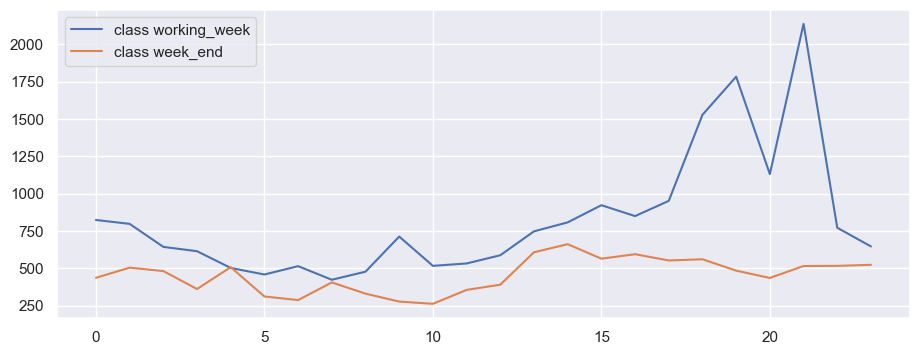

In [78]:
plt.figure()
day = 5
#for i,(c,d) in enumerate(zip([monday, tuesday, wednesday, turhday, friday, saturday, sunday],
#                             ['monday', 'tuesday', 'wednesday', 'turhday', 'friday', 'saturday', 'sunday'])):

for i,(c,d) in enumerate(zip([working_week, week_end],
                             ['working_week', 'week_end'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

Разбиваем на обучающую и тестовую выборку

In [79]:
X = np.concatenate((
                    working_week, 
                    week_end
                   ))
y = np.concatenate((
                    0*np.ones(working_week.shape[0]),
                    1*np.ones(week_end.shape[0]),
                   ))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37, 24) (37,) (16, 24) (16,)


In [80]:
from sktime.datatypes import convert_to
df_train = convert_to(np.atleast_3d(X_train).transpose(0,2,1), to_type="nested_univ") 
df_test  = convert_to(np.atleast_3d(X_test ).transpose(0,2,1), to_type="nested_univ") 

Используем классификатор на основе признаков

In [81]:
from sktime.classification.interval_based import (TimeSeriesForestClassifier, 
                                                  RandomIntervalSpectralEnsemble, 
                                                  SupervisedTimeSeriesForest)
clf = TimeSeriesForestClassifier(n_estimators=100,random_state=47)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score TimeSeriesForestClassifier {test_score:.3f}')
table = pd.DataFrame([['TimeSeriesForestClassifier', test_score]], columns=['method', 'test_score'])

clf = RandomIntervalSpectralEnsemble(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score RandomIntervalSpectralEnsemble {test_score:.3f}')
table2 = pd.DataFrame([['RandomIntervalSpectralEnsemble', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

clf = SupervisedTimeSeriesForest(n_estimators=100, random_state=47)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score SupervisedTimeSeriesForest {test_score:.3f}')
table2 = pd.DataFrame([['SupervisedTimeSeriesForest', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])


 test score TimeSeriesForestClassifier 0.875
 test score RandomIntervalSpectralEnsemble 0.875
 test score SupervisedTimeSeriesForest 0.875


Используем классификатор на основе шейплетов

In [82]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

clf = ShapeletTransformClassifier(estimator=RandomForestClassifier(n_estimators=100),
                                  n_shapelet_samples=100,
                                  max_shapelets=100,
                                  batch_size=20)

clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score ShapeletTransformClassifier {test_score:.3f}')
table2 = pd.DataFrame([['ShapeletTransformClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])


 test score ShapeletTransformClassifier 0.875


Используем 1-NN DTW классификатор

In [83]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="ddtw")
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score KNeighborsTimeSeriesClassifier {test_score:.3f}')
table2 = pd.DataFrame([['KNeighborsTimeSeriesClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])


 test score KNeighborsTimeSeriesClassifier 0.812


Используем классификаторы sclearn

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score RandomForestClassifier {test_score:.3f}')
table2 = pd.DataFrame([['RandomForestClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f' test score KNeighborsClassifier {test_score:.3f}')
table2 = pd.DataFrame([['KNeighborsClassifier', test_score]], columns=['method', 'test_score'])
table = pd.concat([table, table2])

 test score RandomForestClassifier 0.875
 test score KNeighborsClassifier 0.875


In [85]:
table

,method,test_score
0,TimeSeriesForestClassifier,0.8750
0,RandomIntervalSpectralEnsemble,0.8750
0,SupervisedTimeSeriesForest,0.8750
0,ShapeletTransformClassifier,0.8750
0,KNeighborsTimeSeriesClassifier,0.8125
0,RandomForestClassifier,0.8750
0,KNeighborsClassifier,0.8750


В целом классификаторы справляются с задачей классификации, но оценить, какой из методов более точный достаточно сложно из-за недостаточности тестовой выборки. При этом наибольшое постоянство на показателе 0.875 показывают методы на основе словарей.

<h2>6. Классификация при помощи глубоких нейронных сетей в пакете tsai</h2>

In [86]:
from tsai.all import *
import warnings


In [87]:
computer_setup()

os              : Windows-10-10.0.22621-SP0
python          : 3.11.5
tsai            : 0.3.7
fastai          : 2.7.13
fastcore        : 1.5.29
torch           : 2.0.1+cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.78 GB
GPU memory      : [2.0] GB


Разделяем выборку на на тренировочную, валидационную и тестовую

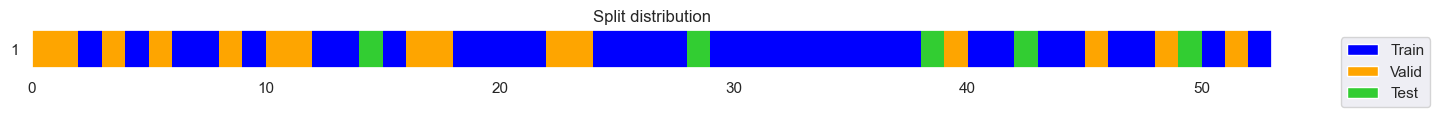

((#33) [4,34,32,30,12,6,21,41,19,15...],
 (#15) [16,3,11,22,1,23,5,8,51,10...],
 (#5) [38,28,49,14,42])

In [88]:
splits = get_splits(y, 
                    n_splits=1, 
                    valid_size=0.3, 
                    test_size=0.1, 
                    shuffle=True, 
                    balance=False, 
                    stratify=True,
                    random_state=42, 
                    show_plot=True, 
                    verbose=True)
splits

In [137]:
X = np.atleast_3d(X.astype('float')).transpose(0,2,1)
y = y.astype('float')

print(X.shape, y.shape)
print (y)

(53, 24, 1) (53,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1.]


Создадим набор данных. Такой набор будет экземпляром класса TSDatasets. В наборе данных зададим разделение данных и необходимые преобразования tfms.

Также сконфигурируем загрузчик батчей TSDataLoaders. Загрузим тренировочный и валидационный наборы данных.

In [138]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

bs = 4
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

Среди анализируемых архитектур мы рассмотрим рекуррентные RNN, LSTM и GRU с 3 и 4 слоями: как двунаправленные, так и однонаправленные варианты.  Кроме рекуррентных нейронных сетей мы также попробуем ряд стандартных сверточных архитектур, таких как ResNet1d, InceptionTime, XceptionTime и TCN. 

In [143]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),   
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),  
         (LSTM,    {'n_layers':3, 'bidirectional': False}), 
         (RNN,     {'n_layers':3, 'bidirectional': True} ), 
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),   
         (ResNet, {}), 
         (InceptionTime, {}), 
         (XceptionTime,  {}), 
         (TCN, {}),   
         (LSTM_FCN, {}), 
         (TST, {}),
         (FCN, {}),   
        ]

По результатам обучения каждой модели мы занесем в таблицу полученные результаты, в том числе точность для валидационного набора данных и время обучения.

In [144]:
from IPython.display import clear_output

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):
   
    model = create_model(arch, dls=dls, **k)
    
    print(model.__class__.__name__)
    
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,ResNet,{},490242,0.168145,0.319652,0.933333,9
1,InceptionTime,{},459522,0.145057,0.339814,0.933333,14
2,LSTM_FCN,{},326330,0.177946,0.315946,0.933333,7
3,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",584402,0.344347,0.420364,0.866667,8
4,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",438402,0.237377,0.379734,0.866667,7
5,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",73402,0.161649,0.557874,0.866667,5
6,LSTM,"{'n_layers': 3, 'bidirectional': False}",212202,0.375471,0.394183,0.866667,6
7,LSTM,"{'n_layers': 3, 'bidirectional': True}",584402,0.279884,0.450419,0.866667,8
8,GRU,"{'n_layers': 3, 'bidirectional': True}",438402,0.275538,0.499220,0.866667,7
9,XceptionTime,{},402900,0.614880,0.630222,0.866667,15


Наилучший результат по точности и времени показал LSTM-FCN. Этот алгоритм состоит из 2 частей: блока LSTM и части FCN с 3 слоями свертки.

In [145]:
arch = LSTM_FCN
k = {}
model = create_model(arch, dls=dls, **k)
model = build_ts_model(arch, arch_config=k, dls=dls)

Определим оптимальную скорость обучения.

SuggestedLRs(valley=0.00363078061491251)

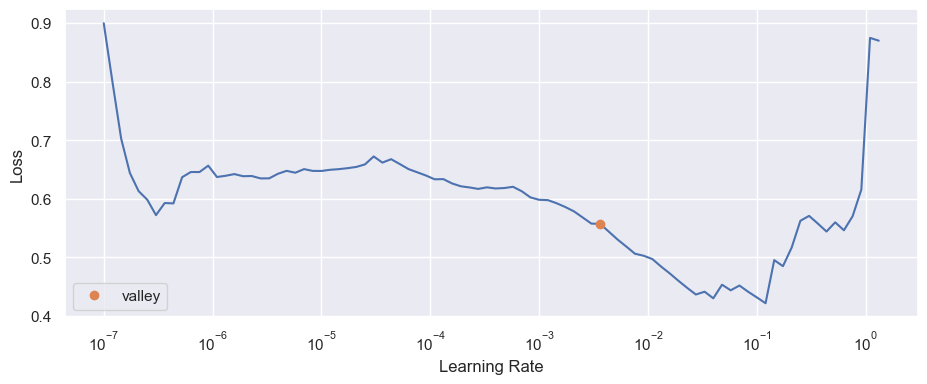

In [147]:
learn = ts_learner(dls, arch=model, metrics=accuracy) 
learn.lr_find()

Запускаем обучение

epoch,train_loss,valid_loss,accuracy,time
0,0.246692,0.284056,0.866667,00:00
1,0.227220,0.301690,0.866667,00:00
2,0.215713,0.295167,0.866667,00:00
3,0.214718,0.274007,0.866667,00:00
4,0.232883,0.269979,0.866667,00:00
5,0.237879,0.278670,0.866667,00:00
6,0.219451,0.254222,0.866667,00:00
7,0.192366,0.236859,0.866667,00:00
8,0.186211,0.226414,0.866667,00:00
9,0.170492,0.275283,0.866667,00:00


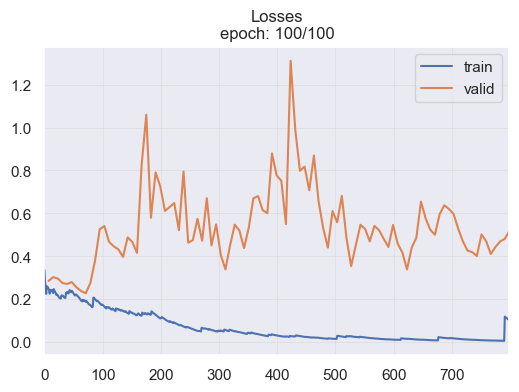

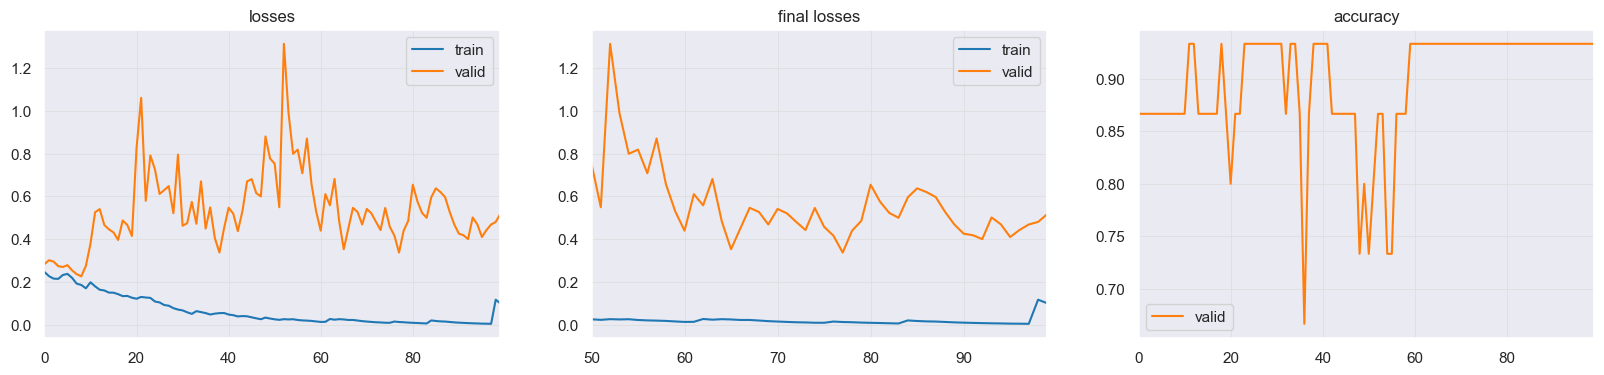

In [149]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.0036, cbs=ShowGraph())

Выводим матрицу ответов

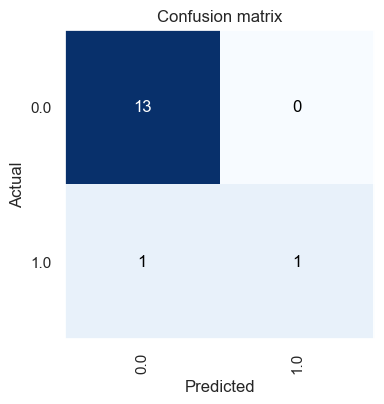

In [150]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [182]:
probas, _, preds = learn.get_X_preds(X[splits[2]])
from sklearn.metrics import accuracy_score

print(y[splits[2]])
print(probas)

accuracy_score(np.argmax(probas,axis=-1),y[splits[2]])

[0. 0. 1. 0. 0.]
tensor([[9.3694e-01, 6.3065e-02],
        [1.0000e+00, 2.2453e-09],
        [9.9887e-01, 1.1264e-03],
        [9.9998e-01, 2.2884e-05],
        [9.4686e-01, 5.3144e-02]])


0.8

Оценивать качаство классификации на временном ряду из 53 дней достаточно сложно из-за недостаточности тестовой выборки. Если брать по валидационной выборке, то LSTM-FCN показал наилучший результат из примененных методов.

<h2>7. Выявление аномалий во временном ряду<h2>

In [249]:
data = data.drop(['h','day_of_the_week'], axis=1)

In [250]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(data)
anomalies.values.sum()

28

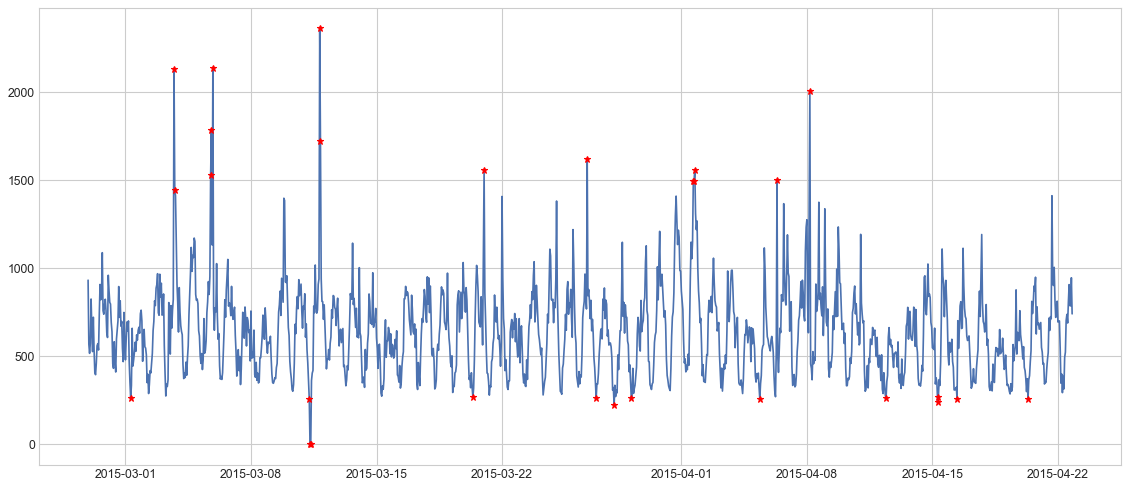

In [255]:
data2 = data.copy()
data2['a'] = anomalies['value']
data_a = data2[data2['a'] == True].copy()

figure(figsize=(14, 6), dpi=80, layout='constrained')
plt.plot(data.value)
plt.plot(data_a.value, color='red', marker='*', linestyle='', label = "anomalies")

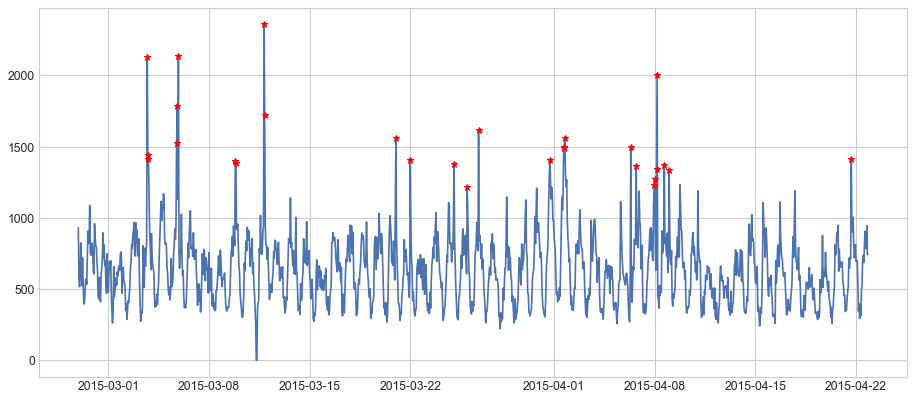

In [259]:
from adtk.detector import SeasonalAD
seasonal_vol = SeasonalAD()
anomalies = seasonal_vol.fit_detect(data.value)

data2 = data.copy()
data2['a'] = anomalies
data_a = data2[data2['a'] == True].copy()

figure(figsize=(14, 6), dpi=80)
plt.plot(data.value)
plt.plot(data_a.value, color='red', marker='*', linestyle='',)

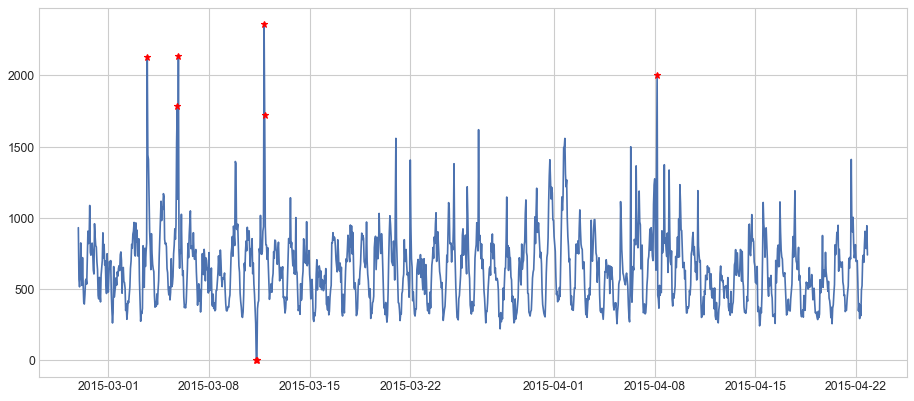

In [316]:
y = data.value.values.reshape(-1, 1)

from sklearn.cluster import DBSCAN, KMeans
model=DBSCAN(eps = 100., min_samples = 5)
#model = KMeans(n_clusters=2)

model.fit(y)
colors = model.labels_
cls,counts = np.unique(colors, return_counts=True)
sort_idx = np.argsort(counts)

data2 = data.copy()
data2['a'] = colors
data_a = data2[data2['a'] == -1].copy()

figure(figsize=(14, 6), dpi=80)
plt.plot(data.value)
plt.plot(data_a.value, color='red', marker='*', linestyle='',)

Проведён анализ временного ряда на наличие аномалий тремя методами QuantileAD, SeasonalAD, DBSCAN.

По визуальному анализу графиков лучше всех сработал DBSCAN, который выявил как нулевое значение, так и пики выше 1500 упоминаний. SeasonalAD выявил только максимумы, при чём собрал максимальное их количество. QuantileAD записал в аномалии минимальные значения по недельным циклам, что не совсем корректно.

Природой таких аномалий могут быть:</br>
- временно неработающий Твиттер (для нулевых значений);
- громкий инфоповод у Амазона (для максимумов).



<h2>Заключение

В работе был проанализирован временной ряд упоминаний интернет-магазина Амазон в социальной сети Твиттер.

Были выполнены:
- предварительный анализ временного ряда;
- предсказание значений с использованием различных методов;
- предсказание значений с использованием SARIMA;
- сравнение модели SARIMA и использованных методов;
- классификация сегментов временного ряда с использованием различных методов;
- классификация сегментов временного ряда с использованием нейронных сетей;
- поиск аномалий.

При выполнении заданий были освоены теория и практика по анализу и моделированию временных рядов.